### Category 4 - Timeseries Forecasting using ARIMA - Champagne Sales

Dataset contains monthly champagne sales from Jan 1964 till Sep 1972. The goal is to predict the sales volume for the next 6 months from Oct 1972 to March 1973. This notebook goes through the basic steps of time series forecasting using ARIMA.

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
from numpy import sqrt, log, mean
from scipy.stats import boxcox
from pandas import Series,concat
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import pyplot
from pandas import TimeGrouper
from sklearn.metrics import mean_squared_error

In [2]:
# Load dataset
train_filename = './0.datasets/champagne.csv'  #Change path accordingly.

champagne = Series.from_csv(train_filename, header=0)
print(champagne.head())
print(champagne.size)

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Sales, dtype: int64
105


In [3]:
# Split the data so that we use the last 12 months for validation
split_point = len(champagne)-12
dataset,validation = champagne[0:split_point],champagne[split_point:]
print(len(dataset))
print(len(validation))

93
12


In [4]:
# Create the persistence model - Baseline prediction
# The persistence model uses the value in the previous timestep (month in this case) as the prediction for the next time step
X = dataset.values.astype('float32')
#X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 3186.501


** Data Analysis on Time series data **

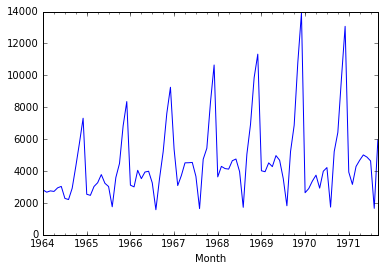

In [5]:
# Line Plot
dataset.plot()
plt.show()

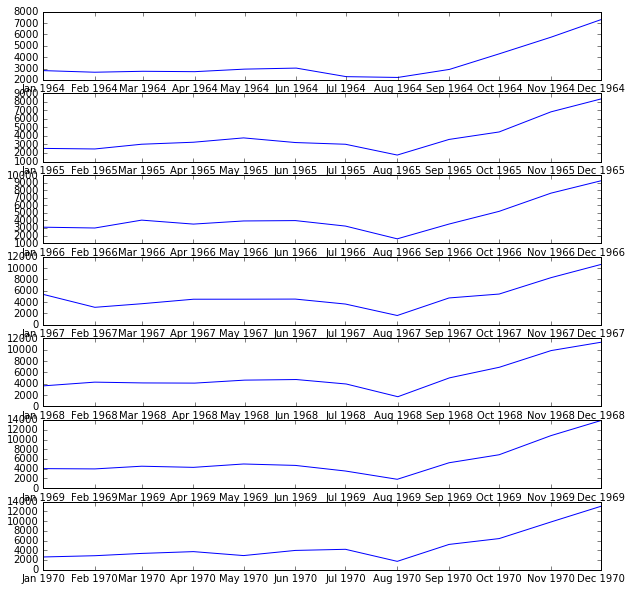

In [6]:
# Seasonal line plots
groups = dataset['1964':'1970'].groupby(TimeGrouper('A'))
years = pd.DataFrame()
plt.figure(figsize=(10,10))
i = 1
n_groups = len(groups)
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i += 1
    pyplot.plot(group)
plt.show()

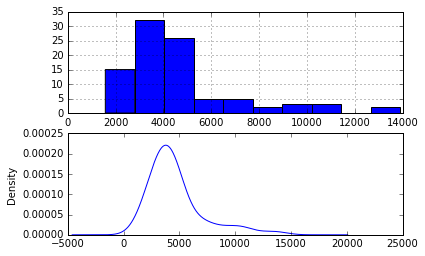

In [7]:
# Density plot
plt.figure(1)
plt.subplot(211)
dataset.hist()
plt.subplot(212)
dataset.plot(kind='kde')
plt.show()

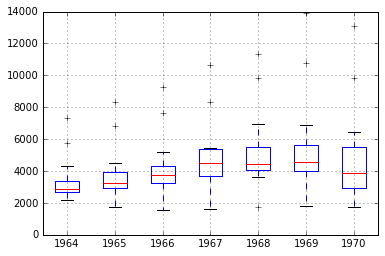

In [8]:
# Box Whisker plots
groups = dataset['1964':'1970'].groupby(TimeGrouper('A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

** ARIMA Models **

C:\Users\Karthikeyan\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ADF Statistic: -7.134898
p-value: 0.000000
Critical Values:
	1%: -3.515
	10%: -2.586
	5%: -2.898


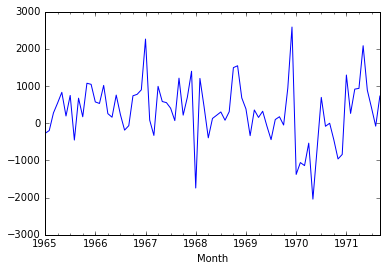

In [9]:
# create and summarize stationary version of time series
from statsmodels.tsa.stattools import adfuller

# create a differenced series
def difference(X, interval=1):  # X-Timeseries dataset passed to the function
    diff = list()
    for i in range(interval, len(X)):
        value = X[i] - X[i - interval]
        diff.append(value)
    return Series(diff)

X = dataset.values
X = X.astype('float32')

# Stationarized time series is created by differencing it by 12 months, i.e. same month last year
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = dataset.index[months_in_year:]

# check if stationary using the ADF test
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot
stationary.plot()
plt.show()

Dicky Fuller Test gives a test statistic values of -7.13 which is lesser than the critical value at 1% confidence. So the null hypothesis is rejected. Rejecting the null hypothesis means that the process has no unit root and that the time series is stationary (or) does not have a time dependent structure

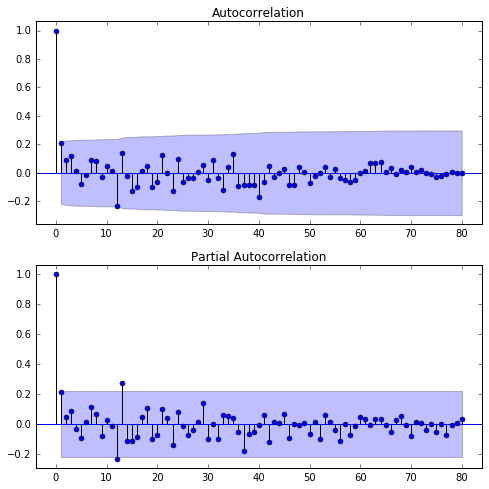

In [10]:
# ACF and PACF plots of time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(8,8))
plt.subplot(211)
plot_acf(stationary, ax=pyplot.gca())
plt.subplot(212)
plot_pacf(stationary, ax=pyplot.gca())
plt.show()

** Functions that encapsulate ARIMA modeling **

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
import warnings

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order,bias=0):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = bias + inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        # observation
        obs = test[t]
        history.append(obs)
    # errors
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return (rmse,residuals)


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(X, p_values, d_values, q_values):  # X is the timeseries dataset passed to the function
    X = X.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse,residuals = evaluate_arima_model(X, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [12]:
# evaluate manually configured ARIMA model
warnings.filterwarnings("ignore")
X=dataset.values
order=(0,0,1)
rmse_manually_configured, residuals = evaluate_arima_model(X, order)
print("Manually configured ARIMA RMSE:")
print(rmse_manually_configured)

Manually configured ARIMA RMSE:
939.4641610637135


In [13]:
# grid search ARIMA parameters for time series
# load dataset
X = dataset.values
# evaluate parameters
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=939.464
ARIMA(0, 1, 1) RMSE=958.292
ARIMA(1, 0, 0) RMSE=944.449
ARIMA(1, 1, 0) RMSE=1070.204
ARIMA(1, 1, 1) RMSE=956.940
Best ARIMA(0, 0, 1) RMSE=939.464


** We will select ARIMA (0,0,1) model going forward **

ARIMA RMSE:
924.6991573497702
                 0
count    47.000000
mean     -0.000001
std     934.696196
min   -2330.152177
25%    -455.556395
50%      25.854820
75%     567.087459
max    2201.399879


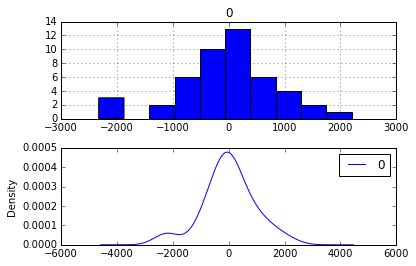

In [14]:
# evaluate residuals from the selected ARIMA model
warnings.filterwarnings("ignore")
order=(0,0,1)
rmse, residuals = evaluate_arima_model(X, order,bias = 165.904728)
print("ARIMA RMSE:")
print(rmse)

residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=pyplot.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
plt.show()

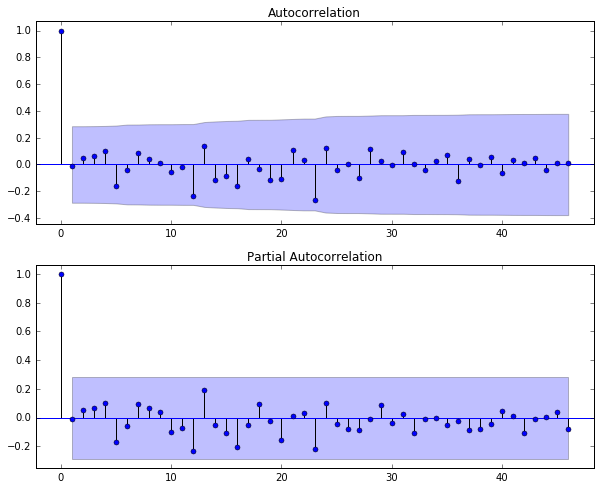

Plots show that no auto correlation is present in the residuals


In [15]:
# plot ACF & PACF on residuals
plt.figure(figsize=(10,8))
plt.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
plt.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
plt.show()
print("Plots show that no auto correlation is present in the residuals")

In [16]:
# ARIMA model for final validation & prediction
def final_arima_model(X, y, arima_order,bias=0):  
    # load and prepare datasets
    history = [x for x in X]
    months_in_year = 12
    diff = difference(X, months_in_year)
    # fit model
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)    
    
    # make first prediction
    predictions = list()
    yhat = float(model_fit.forecast()[0])
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    history.append(y[0])       
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
    
    # rolling forecasts
    for i in range(1, len(y)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        # predict
        model = ARIMA(diff, order=(0,0,1))
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = bias + inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        # observation
        obs = y[i]
        history.append(obs)
        #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
        # report performance
    rmse = sqrt(mean_squared_error(y, predictions))
    print('RMSE: %.3f' % rmse)
    plt.plot(y)
    plt.plot(predictions, color='red')
    plt.show()
    return predictions

RMSE: 361.110


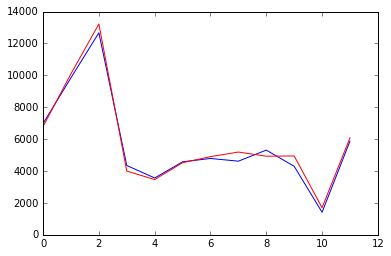

In [17]:
# Use the validation dataset (12 months) to check the accuracy of the model
warnings.filterwarnings("ignore")
X = dataset.values.astype('float32')
y = validation.values.astype('float32')
order=(0,0,1)
bias = 165.904728
predictions = final_arima_model(X, y, order,bias)

** Predict on Test Set - 6 months **

In [18]:
# Load dataset
test_filename = './0.datasets/champagne_test.csv'

champagne_test = Series.from_csv(test_filename, header=0)
print(champagne_test.size)

6


RMSE: 6244.968


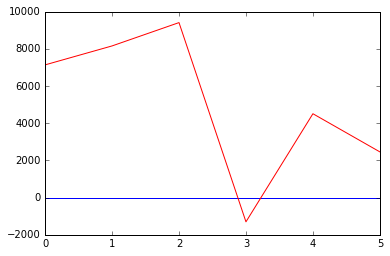

[7135.7201898207677, 8154.0306614042593, 9408.5661640261314, -1302.3037952028785, 4509.1539323938487, 2457.9397995344989]


In [19]:
warnings.filterwarnings("ignore")
X = champagne.values.astype('float32')
y = champagne_test.values.astype('float32')

order=(0,0,1)
bias = 165.904728
final_predictions = final_arima_model(X, y, order,bias)
print(final_predictions)

In [20]:
final_df = pd.DataFrame(champagne_test).reset_index()
final_df['Sales'] = final_predictions

In [21]:
final_df

,Month,Sales
0,1972-10-01,7135.720190
1,1972-11-01,8154.030661
2,1972-12-01,9408.566164
3,1973-01-01,-1302.303795
4,1973-02-01,4509.153932
5,1973-03-01,2457.939800


The results can be further improved by having power transforms done to the sales data. As indicated earlier, this notebook is a basic illustration of using ARIMA for time series forecasting. More complex techniques to follow...